<a href="https://colab.research.google.com/github/seyonechithrananda/ncov-ligand-protein/blob/master/covid_mpro_balanced_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we train a RF model with parameters selected from hyperparameter tuning on a combined dataset of 12,000 SMILES strings, 447 of which are positive hits for the SARS-COV-1 3clpro protease inhibition. We split the dataset into train and test splits utilizing scaffold splitting. The model is finally tested on a SARS-COV-2 3clpro inhibition assay of 880 molecules, 78 of which are positive for binding to the Mpro/3clpro protease. 

In [2]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2020-04-29 22:54:36--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   165MB/s    in 0.5s    

2020-04-29 22:54:36 (165 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [3]:
import tensorflow as tf
print("tf.__version__: %s" % str(tf.__version__))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


tf.__version__: 2.2.0-rc3
Found GPU at: /device:GPU:0


In [4]:
!git clone https://github.com/deepchem/deepchem.git

Cloning into 'deepchem'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 30693 (delta 126), reused 177 (delta 114), pack-reused 30490
Receiving objects: 100% (30693/30693), 437.91 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (22652/22652), done.


In [5]:
%cd deepchem/

/content/deepchem


In [6]:
!python setup.py install

     |████████████████████████████████| 110 kB 4.9 MB/s 
running install
[pbr] Writing ChangeLog
[pbr] Generating ChangeLog
[pbr] ChangeLog complete (0.1s)
[pbr] Generating AUTHORS
[pbr] AUTHORS complete (0.1s)
running build
running build_py
creating build
creating build/lib
creating build/lib/deepchem
creating build/lib/deepchem/hyper
creating build/lib/deepchem/hyper/tests
copying deepchem/hyper/tests/__init__.py -> build/lib/deepchem/hyper/tests
copying deepchem/hyper/tests/test_hyperparam_opt.py -> build/lib/deepchem/hyper/tests
creating build/lib/deepchem/feat
copying deepchem/feat/binding_pocket_features.py -> build/lib/deepchem/feat
copying deepchem/feat/__init__.py -> build/lib/deepchem/feat
copying deepchem/feat/raw_featurizer.py -> build/lib/deepchem/feat
copying deepchem/feat/base_classes.py -> build/lib/deepchem/feat
copying deepchem/feat/atomic_coordinates.py -> build/lib/deepchem/feat
copying deepchem/feat/graph_features.py -> build/lib/deepchem/feat
copying deepchem/feat

In [0]:
import deepchem as dc

In [8]:
!conda install pandas

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |           py37_0         155 KB
    conda-4.8.3                |           py37_0         2.8 MB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    pandas-1.0.3               |   py37h0573a6f_0         8.6 MB
    ------------------------------------------------------------
                                           Total:        14.1 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> pkgs/main::ca-certificates-2020.1.1-0
  certifi            conda-forge::certifi-2020.4.5.1-py37h~ -->

In [0]:
import os 
import sys 
import pandas as pd

# train --> balanced dataset
dataset_train_file = "/content/drive/My Drive/Project De Novo/AID1706_binarized_sars_full_eval_actives_12k_samples.csv"
dataset_eval_file = "/content/drive/My Drive/Project De Novo/mpro_xchem.csv"
dataset_train = pd.read_csv(dataset_train_file)
dataset_eval = pd.read_csv(dataset_eval_file)

In [10]:
featurizer = dc.feat.CircularFingerprint(size=1024)

loader = dc.data.CSVLoader(
      tasks=["activity"], smiles_field="smiles",
      featurizer=featurizer)
train_data_circular = loader.featurize(dataset_train_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/Project De Novo/AID1706_binarized_sars_full_eval_actives_12k_samples.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 32.609 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
TIMING: featurizing shard 1 took 15.028 s
TIMING: dataset construction took 48.046 s
Loading dataset from disk.


In [11]:
loader_eval = dc.data.CSVLoader(
      tasks=["activity"], smiles_field="smiles", 
      featurizer=featurizer)
test_circular = loader_eval.featurize(dataset_eval_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/Project De Novo/mpro_xchem.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 3.382 s
TIMING: dataset construction took 3.413 s
Loading dataset from disk.


In [11]:
# only generate train + valid datasets, as we already have a test dataset.
splitter_train = dc.splits.ScaffoldSplitter(dataset_train_file)
train_circular, valid_circular = splitter_train.train_test_split(train_data_circular)


Computing train/valid/test indices
About to generate scaffolds
Generating scaffold 0/11999
Generating scaffold 1000/11999
Generating scaffold 2000/11999
Generating scaffold 3000/11999
Generating scaffold 4000/11999
Generating scaffold 5000/11999
Generating scaffold 6000/11999
Generating scaffold 7000/11999
Generating scaffold 8000/11999
Generating scaffold 9000/11999
Generating scaffold 10000/11999
Generating scaffold 11000/11999
About to sort in scaffold sets
TIMING: dataset construction took 0.530 s
Loading dataset from disk.
TIMING: dataset construction took 0.229 s
Loading dataset from disk.


In [0]:
# convert SMILES to Mol + visualize as images

import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    for filename in filenames:
        display(Image(filename))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "BACE_%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
        if i is 10:
          break
    return filenames


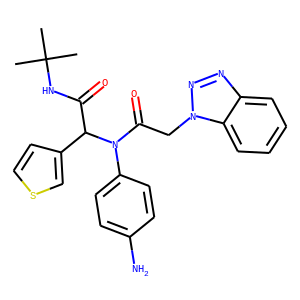

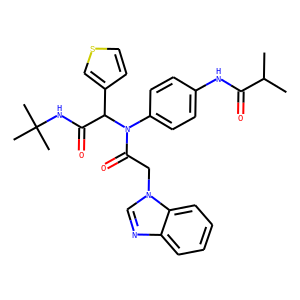

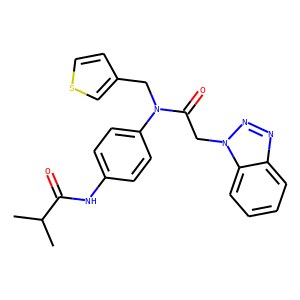

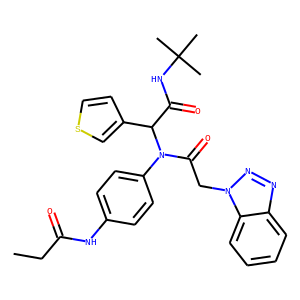

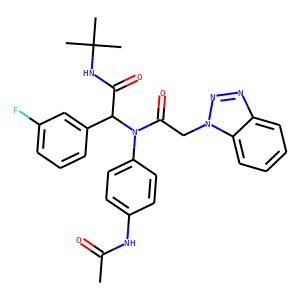

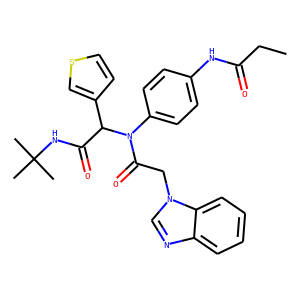

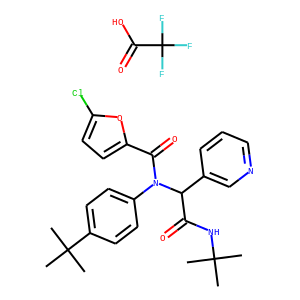

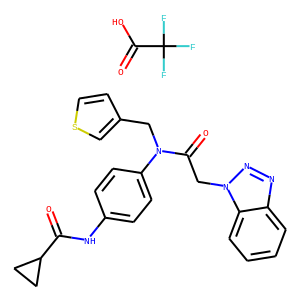

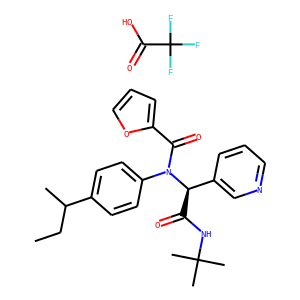

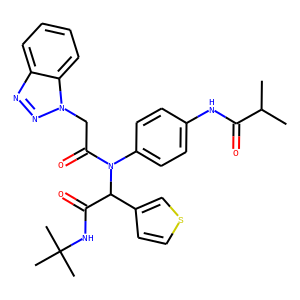

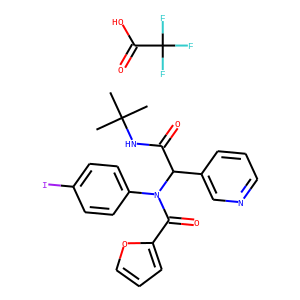

In [13]:
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_circular.ids]
display_images(mols_to_pngs(train_mols, basename="train"))


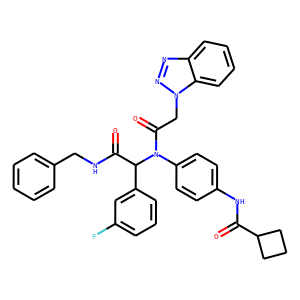

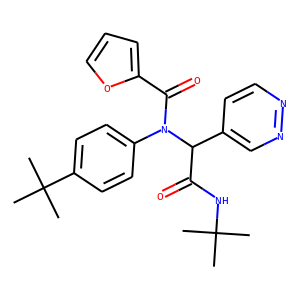

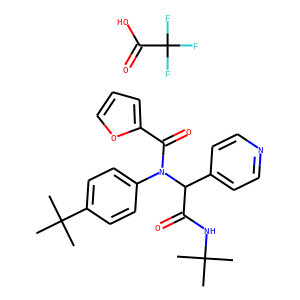

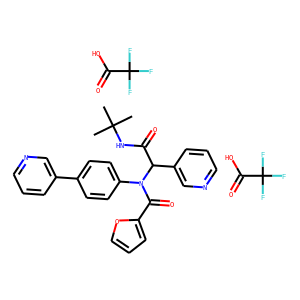

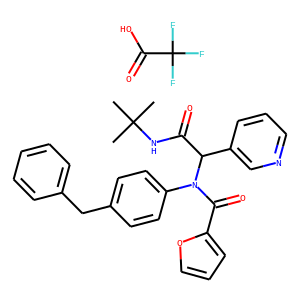

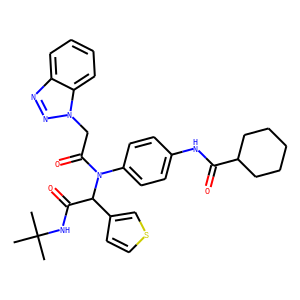

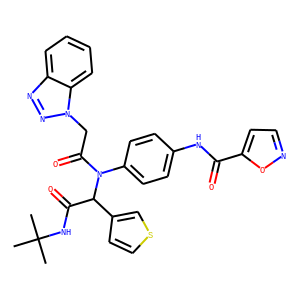

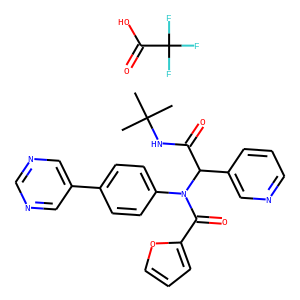

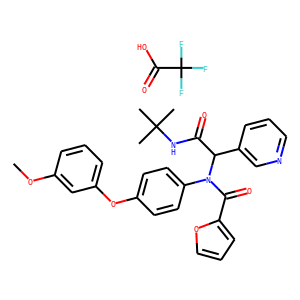

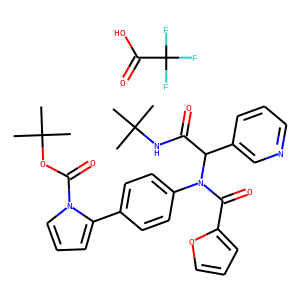

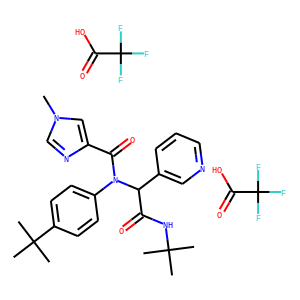

In [14]:
eval_mols = [Chem.MolFromSmiles(compound)
              for compound in valid_circular.ids]
display_images(mols_to_pngs(eval_mols, basename="eval"))

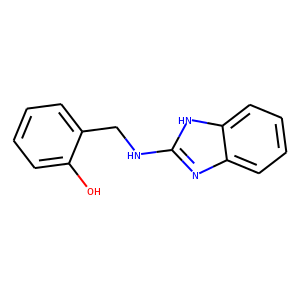

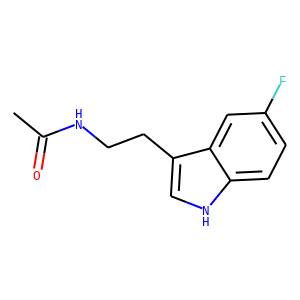

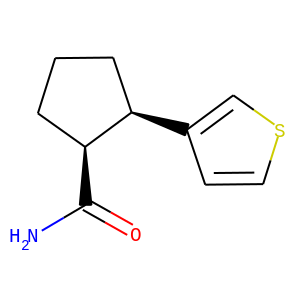

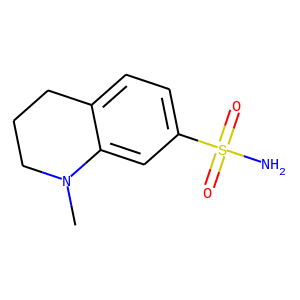

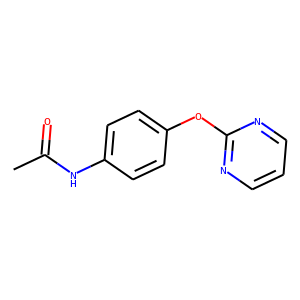

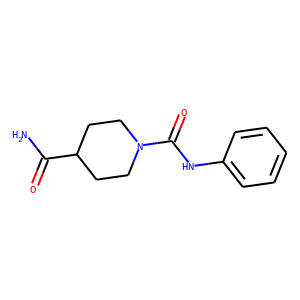

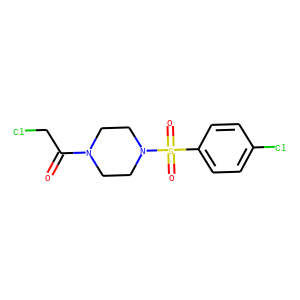

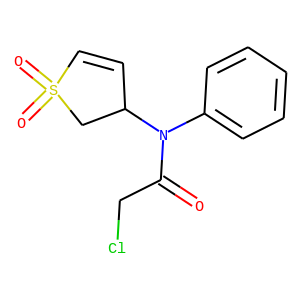

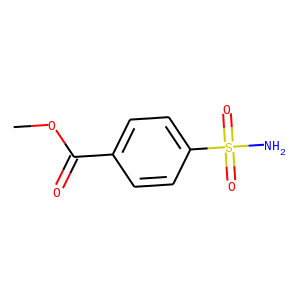

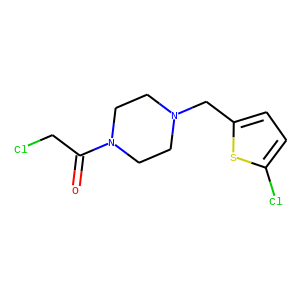

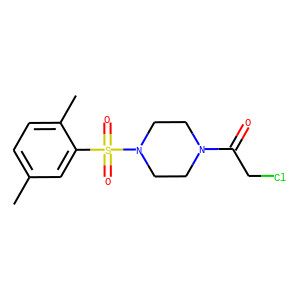

In [15]:
test_mols = [Chem.MolFromSmiles(compound)
              for compound in test_circular.ids]
display_images(mols_to_pngs(test_mols, basename="eval"))

In [12]:
# install sklearn
!conda install scikit-learn


Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          46 KB
    scikit-learn-0.22.1        |   py37h22eb022_0         5.3 MB
    ------------------------------------------------------------
                                           Total:         5.3 MB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/linux-64::blas-1.0-openblas

The following packages will be SUPERSEDED by a higher-priority channel:

  scikit-learn       conda-forge::scikit-learn-0.22.2.post~ --> pkgs/main::scikit-learn-0.22.1-py37h22eb022_0


Proceed ([y]/n)? y


blas-1.0             | 46 KB     | : 100% 1.0/1 [00:00<00

In [1]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth = 2, n_estimators=1000, max_features='log2', class_weight='balanced')
model.fit(train_circular.X, train_circular.y)


NameError: ignored

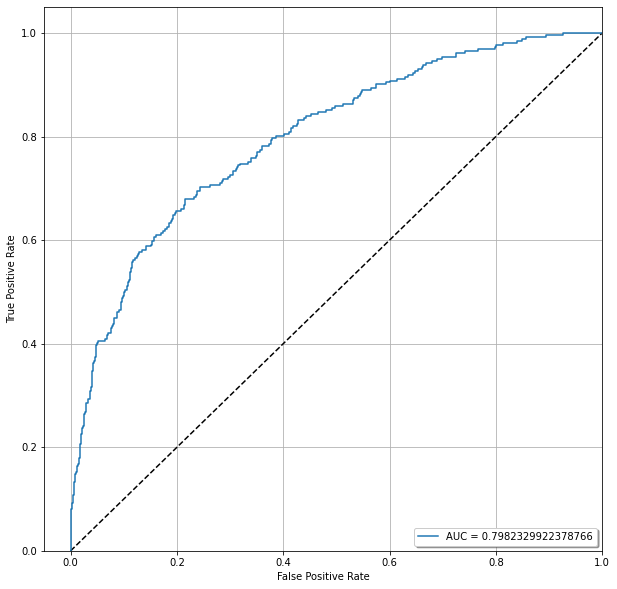

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = model.score(valid_circular.X, valid_circular.y)

# get roc/auc info
y_mol_score = model.predict_proba(valid_circular.X)[:,1]

fpr = dict()
tpr = dict()
fpr, tpr, _= roc_curve(valid_circular.y, y_mol_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

#make plot 
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()


In [20]:
print(y_mol_score)
print(valid_circular.y)

print(roc_auc)
print (acc)

[0.59182236 0.56294438 0.57801522 ... 0.48788869 0.496898   0.42595664]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.7982329922378766
0.8908333333333334


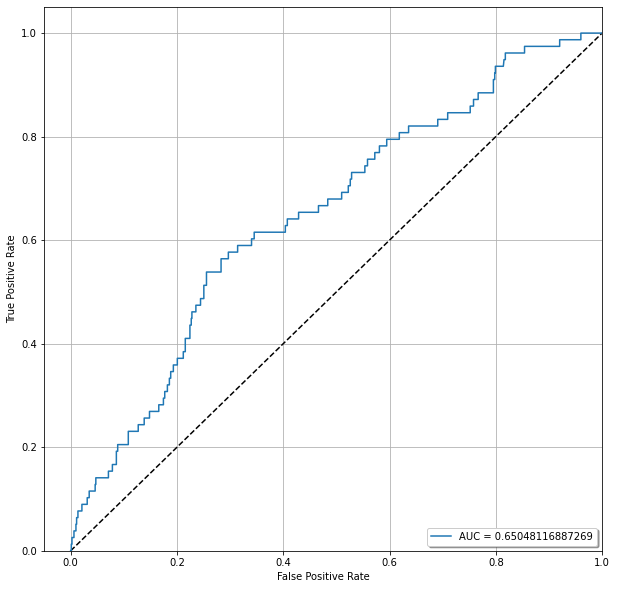

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = model.score(test_circular.X, test_circular.y)

# get roc/auc info
y_mol_score = model.predict_proba(test_circular.X)[:,1]

fpr = dict()
tpr = dict()
fpr, tpr, _= roc_curve(test_circular.y, y_mol_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

#make plot 
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()


In [24]:
print(y_mol_score)
print(test_circular.y)

print(roc_auc)
print (acc)

[0.48196327 0.49106393 0.48184411 0.47191367 0.49285709 0.4618478
 0.48453638 0.5140396  0.49527964 0.48932389 0.49054144 0.48388765
 0.48977436 0.47321972 0.46910984 0.48950896 0.48642975 0.48681228
 0.51910491 0.5099962  0.45906943 0.50093669 0.50899095 0.49663373
 0.4941435  0.49071519 0.49720505 0.48743644 0.49644169 0.47341204
 0.46268092 0.48315003 0.45979931 0.47409091 0.46007441 0.505286
 0.4683068  0.46125951 0.45081283 0.48801879 0.45611917 0.47215358
 0.44678067 0.47787549 0.50321686 0.49536266 0.47910282 0.48652085
 0.4750276  0.47311419 0.4792965  0.4905817  0.49330582 0.47009456
 0.50156846 0.45880178 0.45971938 0.50733567 0.46505273 0.48932927
 0.46584238 0.48874123 0.49194228 0.51656702 0.47139423 0.48859689
 0.49823565 0.49681434 0.48837385 0.49127391 0.47080925 0.47610493
 0.48691949 0.48457273 0.50279259 0.49033863 0.46015304 0.48883521
 0.46294277 0.49058137 0.49125526 0.48448606 0.50507794 0.46391961
 0.47301706 0.46054853 0.48951698 0.47513637 0.45956058 0.4960139

Training the model without any scaffold splits on all SARS-Cov-1 assays

In [13]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth = 2, n_estimators=1000, max_features='log2', class_weight='balanced')
model.fit(train_data_circular.X, train_data_circular.y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

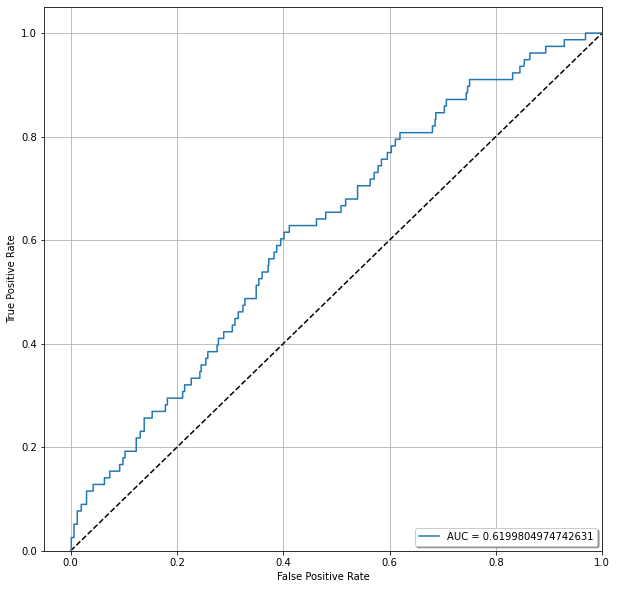

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = model.score(test_circular.X, test_circular.y)

# get roc/auc info
y_mol_score = model.predict_proba(test_circular.X)[:,1]

fpr = dict()
tpr = dict()
fpr, tpr, _= roc_curve(test_circular.y, y_mol_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

#make plot 
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()


In [15]:
print(y_mol_score)
print(test_circular.y)

print(roc_auc)
print (acc)

[0.49016054 0.5062538  0.48256007 0.48766744 0.50545033 0.47479284
 0.4955488  0.51612306 0.51126333 0.49204764 0.49504914 0.50284899
 0.4894258  0.48357111 0.4818651  0.49229853 0.4933208  0.49170683
 0.52094834 0.51901739 0.46855445 0.52107752 0.52772406 0.50285526
 0.49480878 0.49104543 0.50203062 0.49376822 0.50332481 0.48392712
 0.47696937 0.49621978 0.47465037 0.48471645 0.46798176 0.51270751
 0.47678343 0.46998825 0.47774705 0.50946802 0.47482712 0.48157475
 0.45878137 0.49000681 0.5127458  0.50425811 0.5009958  0.49658436
 0.48575998 0.48522499 0.47784061 0.49058095 0.49108259 0.4867783
 0.50408338 0.46560341 0.46370625 0.51884728 0.47800445 0.49425094
 0.48300743 0.49387067 0.49829412 0.52816048 0.48213846 0.49865437
 0.50085373 0.50528079 0.49746593 0.49669266 0.48459673 0.49595222
 0.49040879 0.48315483 0.50827869 0.4923128  0.46902902 0.49316711
 0.4771622  0.4938518  0.49667446 0.49569608 0.51206664 0.47941077
 0.49108142 0.47271148 0.50380213 0.49234546 0.47315509 0.51005

Here, we load the best model trained on a Scaffold Split of the train + validation set, and tuned using DeepChem's hyperparameter optimization. We get an AUC of 0.67.

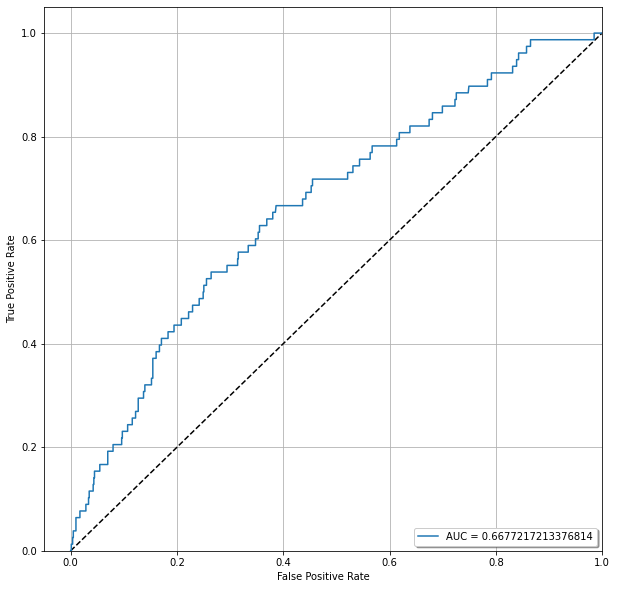

In [19]:
import pickle as cp

with open('/content/drive/My Drive/Project De Novo/output_dir_rf/best_rf_3clpro', 'rb') as f:
    rf = cp.load(f)

acc = rf.score(test_circular.X, test_circular.y)


# get roc/auc info
y_mol_score = rf.predict_proba(test_circular.X)[:,1]

fpr = dict()
tpr = dict()
fpr, tpr, _= roc_curve(test_circular.y, y_mol_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

#make plot 
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()


In [20]:
print(y_mol_score)
print(test_circular.y)

print(roc_auc)
print (acc)

[0.48397556 0.50384618 0.48382362 0.47766082 0.49817213 0.4721163
 0.50194878 0.51728951 0.51306177 0.50172567 0.50031593 0.50262032
 0.49935823 0.48474171 0.490132   0.49443766 0.49707045 0.48748794
 0.51418578 0.50654979 0.47098863 0.52196976 0.52799655 0.50173496
 0.50885399 0.49303277 0.51185569 0.50342841 0.49730366 0.47625226
 0.47361983 0.49544534 0.4721866  0.47894819 0.46866019 0.51121235
 0.47914834 0.46303442 0.46534083 0.49147544 0.46423041 0.47994567
 0.44862718 0.49153681 0.51493434 0.50722042 0.5010723  0.48937079
 0.48096978 0.48021653 0.48441326 0.48890452 0.48730241 0.47740879
 0.49525545 0.46906919 0.46641601 0.52053293 0.4747064  0.50566537
 0.46559857 0.50174437 0.50250342 0.53513902 0.48897837 0.5014678
 0.51026403 0.50556434 0.50421681 0.50484098 0.48804901 0.49584595
 0.50344797 0.49620192 0.52047721 0.50750092 0.474194   0.50123503
 0.47097021 0.48976071 0.47777359 0.49020757 0.51502555 0.47246276
 0.47503771 0.46807398 0.50140571 0.4875033  0.47287051 0.498864